## FieldLab project about NexEd data

#### Importing our libraries and cleaned data

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from cleaning import read_data, clean_linting_results, clean_review_test_results, clean_data_reviewss, clean_data_exercises, clean_data_code_blast_tests

read_linting_results, read_review_test_results, read_reviews, data_tests, read_code_blast_tests, read_exercises, data_implementation_exercise = read_data()

data_linting_result = clean_linting_results(read_linting_results)
data_review_test_results = clean_review_test_results(read_review_test_results)
data_reviews = clean_data_reviewss(read_reviews)
data_exercises = clean_data_exercises(read_exercises)
data_code_blast_tests = clean_data_code_blast_tests(read_code_blast_tests)


### How many times made and how many times declined


#### How many times each exercise?

This code provides us with data of how many times each exercise has been made.

In [10]:
# Merge data_implementation_exercise and data_exercises together
merged_data = pd.merge(data_implementation_exercise, data_exercises, left_on='exercise_id', right_on='id', how='left')

# Group the data based on exercise title and count the amount of exercises made
exercise_counts = merged_data.groupby(['id', 'title']).size().reset_index(name='count')

# We created a filter that only shows us the exercises that has been made more than 500 times.
exercise_counts = exercise_counts[exercise_counts['count'] > 500]

# Keep only the exercise titles with the highest count for each ID
exercise_counts_sorted = exercise_counts.sort_values(by=['count'], ascending=False).drop_duplicates('id')

# Print the final result
print(exercise_counts_sorted[['title', 'count']])

                              title  count
1387  Folders, Files and Structure!  28488
613                    Lintjesregen  21904
389            One Size Fits Nobody  16488
1553                          Input  14580
858               Divide and Style!  14392
...                             ...    ...
670       Fake It 'til You Make It!    520
1284               Play that sound!    518
1146   Putting the Fun in Function!    512
57                         Wildcard    504
1507                   Scope it out    504

[309 rows x 2 columns]


In the output above we get our first insight about all exercises that have been made more than 500 times. We created this filter bases on the bump in amount of exercises made that we saw when we created a barplot showing all exercises.

#### Top 100 exercises that got declined the most

From all exercises with have been made more than 500 times, we wanted to see a top 100 of these that got declined the most to get a better idea what exercises might be too hard or need change

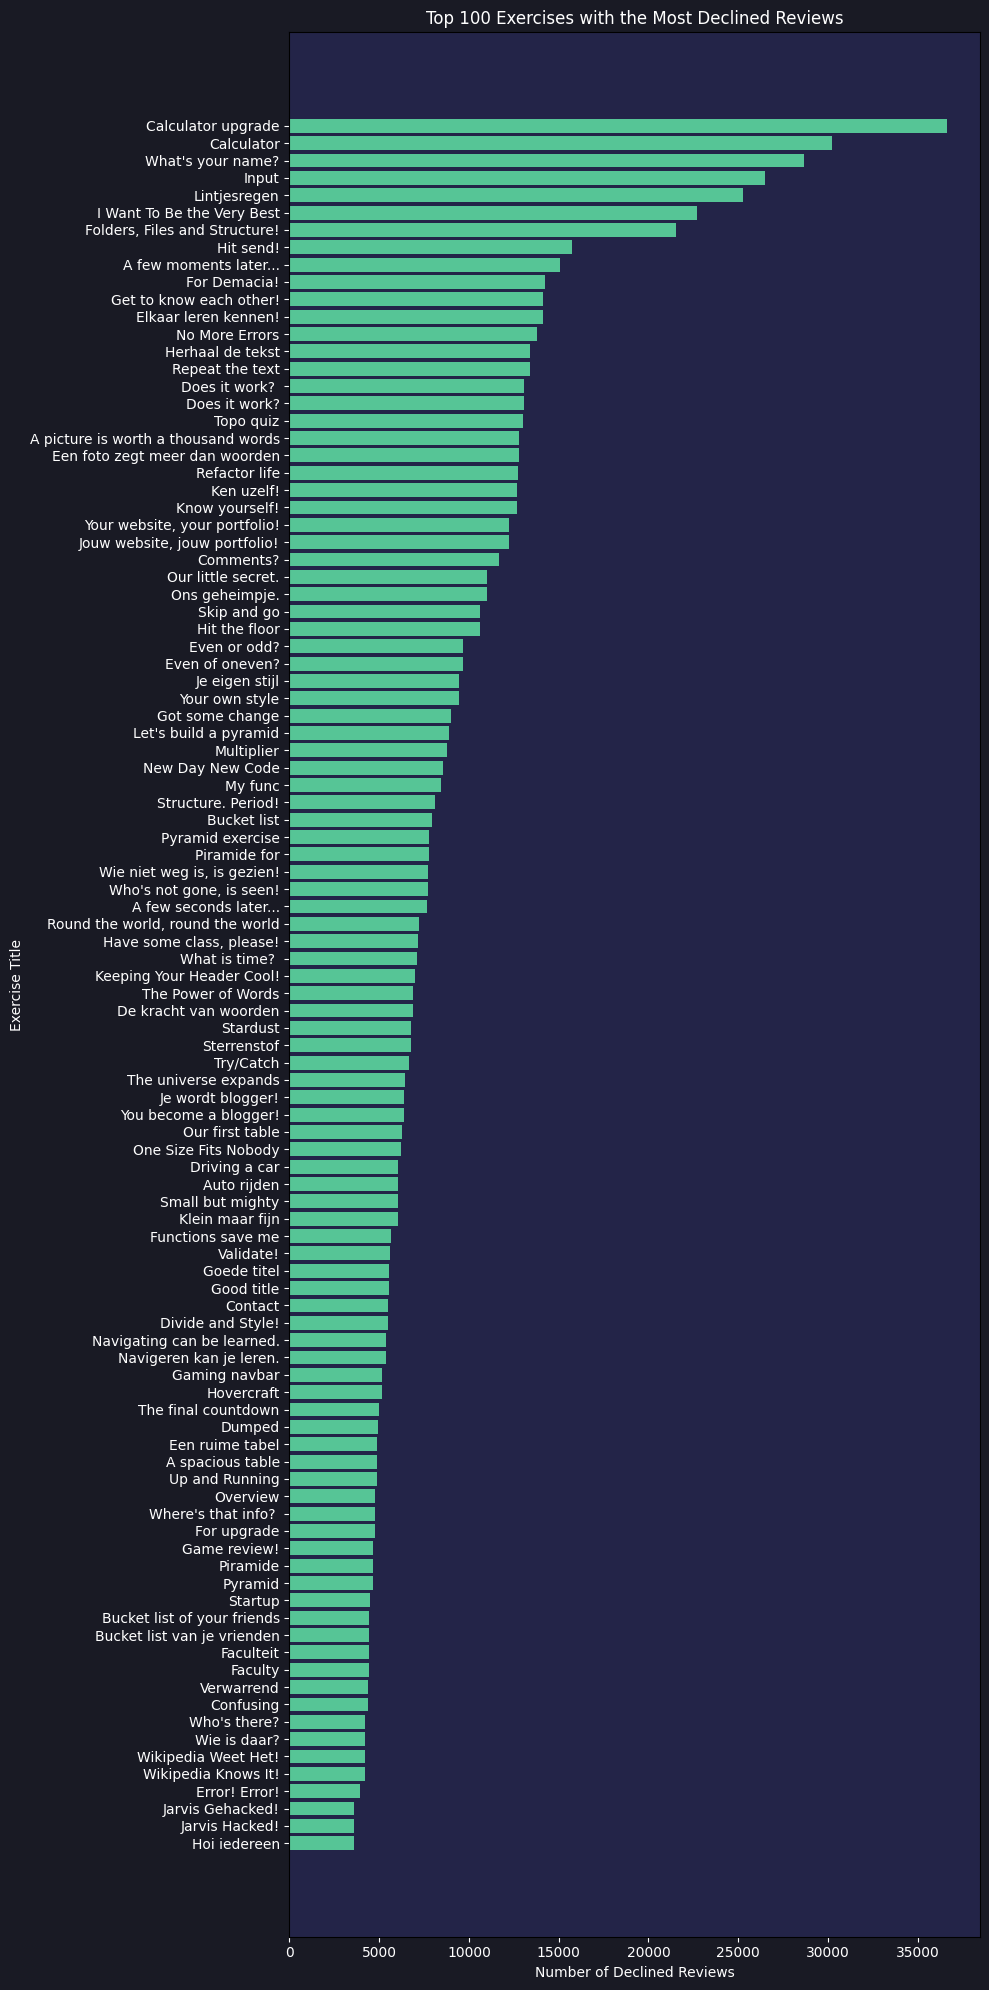

In [11]:

# Filter data_reviews for entries with 'DECLINED' state
declined_reviews = data_reviews[data_reviews['state'] == 'DECLINED']

# Merge declined_reviews with data_implementation_exercise
merged_reviews_impl = pd.merge(declined_reviews, data_implementation_exercise, left_on='implementation_id', right_on='implementation_id', how='inner')

# Merge the result with data_exercises
merged_data = pd.merge(merged_reviews_impl, data_exercises, left_on='exercise_id', right_on='id', how='left')

# Group the data based on exercise title and count the number of declined values
declined_counts = merged_data.groupby(['exercise_id', 'title']).size().reset_index(name='declined_count')

# Get the top 100 exercises with the most declined values
top_declined_exercises = declined_counts.sort_values(by=['declined_count'], ascending=False).head(100)

# Reverse the order of the DataFrame
top_declined_exercises = top_declined_exercises[::-1]

# Create a subplot with a specified background color
fig, ax = plt.subplots(figsize=(10, 20), facecolor='#191A24')

bars = ax.barh(top_declined_exercises['title'], top_declined_exercises['declined_count'], color='#56C596')
ax.set_xlabel('Number of Declined Reviews', color='white')
ax.set_ylabel('Exercise Title', color='white')
ax.set_title('Top 100 Exercises with the Most Declined Reviews', color='white')

# Set text color for ticks on x and y axes
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.tight_layout()
ax.set_facecolor('#232448')

# Show the plot
plt.show()

As we can see in the code above, that there are a couple exercises that really peak out in the amount of declines they get.

#### How many declines did these exercises get?

In the table below we created a easy view to see the exact amount of declined per exercise shown in the barchart from above

In [12]:
# Create a new DataFrame for the table
table_data = top_declined_exercises[['title', 'declined_count']].sort_values(by='declined_count', ascending=False)

# Set the text color and border color
text_color = '#56C596'
border_color = '#191A24'

# Create the table figure
fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Exercise Title<b>', '<b>Declined Count<b>'],
                fill_color=border_color,  # Set border color for header
                line_color=border_color,  # Set border color for header
                font=dict(color=text_color),  # Set text color for header
                align='left'),
    cells=dict(values=[table_data['title'], table_data['declined_count']],
               fill_color='#232448',
               line_color=border_color,  # Set border color for cells
               font=dict(color=text_color),  # Set text color for cells
               align='left'))
])

# Set layout properties for a scrollable table
fig.update_layout(
    height=600,
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0),
)

fig.show()


### Do the human error messages have a positive effect on the exercises being made?


#### We calculate the effect of human error messages

In [13]:
# We select the column we want to use
df_errors = data_review_test_results[['blast_review_id', 'human_error_message']]

# We merge these columns with the data_reviews dataset
df_errors = df_errors.merge(data_reviews[['id', 'implementation_id']], left_on='blast_review_id', right_on='id')

# We fill the exercises without a human error message with a NaN value
df_errors['human_error_message'].fillna('NaN', inplace=True)

# We group the values based on implementation_id and human_error_message, and count the times a exercise has been resubmitted.
df_grouped = df_errors.groupby(['implementation_id', 'human_error_message']).size().reset_index(name='count')

# We filter so we count how many times a excersice has been resubmitted 2 or more times
df_multiple_submissions = df_grouped[df_grouped['count'] >= 2]

# We create 2 dataframes for the data with and without error message
df_with_message = df_multiple_submissions[df_multiple_submissions['human_error_message'] != 'NaN']
df_without_message = df_multiple_submissions[df_multiple_submissions['human_error_message'] == 'NaN']

# We count the amount of resubmitted excersises of these 2 dataframes
total_with_message = df_with_message['count'].sum()
total_without_message = df_without_message['count'].sum()

# We count the total amount of values of both dataframes
total_assignments_with_message = len(df_grouped[df_grouped['human_error_message'] != 'NaN'])
total_assignments_without_message = len(df_grouped[df_grouped['human_error_message'] == 'NaN'])

#  We calculate the amount of resubmitted exercises based on total of each group
normalized_total_with_message = total_with_message / total_assignments_with_message
normalized_total_without_message = total_without_message / total_assignments_without_message

# We calculate the difference between these 2
Difference_with_and_without_errormessage = normalized_total_without_message -normalized_total_with_message

# Round the values ​​to 2 decimal places
normalized_total_with_message = round(normalized_total_with_message, 2)
normalized_total_without_message = round(normalized_total_without_message, 2)
Difference_with_and_without_errormessage = round(Difference_with_and_without_errormessage, 2)

# We print our values
print(f'Total amount of resubmits (2 or more) with human_error_message: {normalized_total_with_message}')
print(f'Total amount of resubmits (2 or more) without human_error_message: {normalized_total_without_message}')
print(f'Exercises without human_error_message get resubmitted {Difference_with_and_without_errormessage}x more than exercises with human_error_message')

Total amount of resubmits (2 or more) with human_error_message: 1.6
Total amount of resubmits (2 or more) without human_error_message: 7.22
Exercises without human_error_message get resubmitted 5.62x more than exercises with human_error_message


Exercises without a human error message are resubmitted significantly more frequently (7.22 times) compared to those with a human error message (1.6 times).
The calculated difference (5.62) indicates that assignments without a human error message are, on average, 5.62 times more likely to be resubmitted compared to those with a human error message.

This suggests that there might be a correlation between the presence of a human error message and the likelihood of an exercise being resubmitted. The higher resubmission rate for exercises without a human error message could indicate a need for clearer instructions or communication regarding errors in the submission process

#### Visualize the effect of human error message to exercises

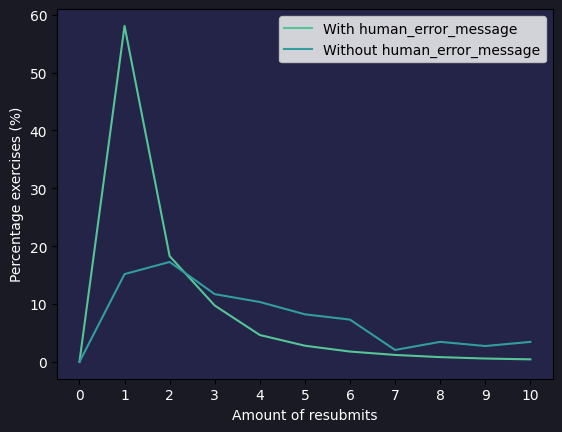

In [14]:
# We delete the filter to only get values from exercises that have been resubmitted 2 or more times
df_grouped_all = df_grouped.copy()

# We create a list for the x axis values
x_values = list(range(11))

# We create the y-values for exercises with and without human error message
y_values_with_message = [len(df_grouped_all[(df_grouped_all['human_error_message'] != 'NaN') & (df_grouped_all['count'] == count)]) / total_assignments_with_message * 100 for count in x_values]
y_values_without_message = [len(df_grouped_all[(df_grouped_all['human_error_message'] == 'NaN') & (df_grouped_all['count'] == count)]) / total_assignments_without_message * 100 for count in x_values]

fig, ax = plt.subplots(facecolor='#191A24')


# We plot the lines
plt.plot(x_values, y_values_with_message, label='With human_error_message', color='#56C596')
plt.plot(x_values, y_values_without_message, label='Without human_error_message', color='#329D9C')

# We add labels to the axis and add a legend
plt.xlabel('Amount of resubmits', color = 'white')
plt.ylabel('Percentage exercises (%)', color = 'white')
plt.legend()

# We make the x axis go up in steps of 1 and change the color of the text
plt.xticks(x_values, color= 'white')
plt.yticks(color='white')


ax.set_facecolor('#232448')


# We plot the visual
plt.show()

We see that exercises with a human error message get declined a lot (~58%) compared to exercises without human error message(~15%). But after the first mistake we see a huge drop in resubmitted exercises(~40%) where there is a human error message. After that we see that the human error message exercises gets resubmitted less then exercises without one.

#### What are the differences of accepted and declined exercises between the dutch and english Jarvis users?

In the code below we gather data from both English and Dutch Jarvis users to create a clear view in differences between accepted and declined exercises.

In [15]:
# We merge data_review_test_results and data_reviews based on 'blast_review_id' and 'id'
merged_data = pd.merge(data_review_test_results, data_reviews, left_on='blast_review_id', right_on='id')

# We filter the languages
filtered_data = merged_data[merged_data['test_language'].isin(['nl', 'en'])]

# Because of the differences in amout of data for the two languages, we filter only the top 500
english_data = filtered_data[filtered_data['test_language'] == 'en'].head(500)
dutch_data = filtered_data[filtered_data['test_language'] == 'nl'].head(500)

# We count the accpeted and declined values for English users
english_counts = english_data['state'].value_counts()

# We count the accpeted and declined values for Dutch users
dutch_counts = dutch_data['state'].value_counts()

# We print the results
print("Amount of ACCEPTED and DECLINED for English user data:")
print(english_counts)

print("\nAmount of ACCEPTED and DECLINED for Dutch user data:")
print(dutch_counts)


Amount of ACCEPTED and DECLINED for English user data:
DECLINED    313
ACCEPTED    187
Name: state, dtype: int64

Amount of ACCEPTED and DECLINED for Dutch user data:
DECLINED    273
ACCEPTED    227
Name: state, dtype: int64


Based on the top 500 Dutch and top 500 English users we see that English Jarvis users get declined a lot more than the Dutch users.
One of the reasons of this could be that the English version of Jarvis is not as clear for students as the Dutch version. 

#### Is this data different for each code language?

With these precentages we get a clear view of the differences between the english and dutch Jarvis users about the exercises that get declined and accepted for each code language.


In [16]:
# We reset the index of data_linting_result
data_linting_result_reset = data_linting_result.reset_index()

# We find the code language using regex
filtered_data = filtered_data.reset_index(drop=True)
filtered_data['code_language'] = data_linting_result_reset['file_name'].str.extract(r'\.(\w+)$')

# We count the number of ACCEPTED and DECLINED for data per code language
counts_by_language = filtered_data.groupby(['test_language', 'code_language', 'state']).size().unstack(fill_value=0)

# We calculate the percentage of ACCEPTED and DECLINED per code language for Dutch users
dutch_percentage_by_language = (
    counts_by_language.loc['nl'].div(counts_by_language.loc['nl'].sum(axis=1), axis=0) * 100
)

# We calculate the percentage of ACCEPTED and DECLINED per code language for English users
english_percentage_by_language = (
    counts_by_language.loc['en'].div(counts_by_language.loc['en'].sum(axis=1), axis=0) * 100
)

# Set the number of decimals
decimals = 1

# Format for printing the results
format_str = "{:." + str(decimals) + "f}%"

# Print the results
print("\nPercentage of ACCEPTED and DECLINED for Dutch users per code language:")
print(dutch_percentage_by_language.map(lambda x: format_str.format(x)).rename_axis(columns={'state': ''}))

print("\nPercentage of ACCEPTED and DECLINED for English users per code language:")
print(english_percentage_by_language.map(lambda x: format_str.format(x)).rename_axis(columns={'state': ''}))


We see that there are bigger gaps between the percentages per code language from the english users. One of the reasons this could be the case is because there are way less english users than dutch users. 

# Test Types
In this visuals we want to discorer the following

* Visualize what test types are being used the most.
* Visualize what test types give the most issues(blast and linter)
* Visualize the top 20 linting errors per linting type
* Visualize blast and linting apart

#### What are the top 20 most common linting issues?

Below we have a list of the top 20 most common linter issues.

In [17]:
linting_error_codes = data_linting_result['message'].value_counts()
linting_error_codes.head(20)

The value of the “for” attribute of the “label” element must be the ID of a non-hidden form control.    25289
 Unexpected token.                                                                                      24405
Missing semicolon.                                                                                      24213
Expected indentation of 4 spaces but found 2.                                                           20769
Expected at least 1 space before "."; 0 found                                                           19739
Element “head” is missing a required instance of child element “title”.                                 19311
 Unexpected beginning of statement.                                                                     18179
Trailing spaces not allowed.                                                                            16970
Expected at least 1 space after "."; 0 found                                                            16569
Expected 1

### How many linting issues are there per test language?

Below we created a visual showing the ammount of linting issues filtered by test language

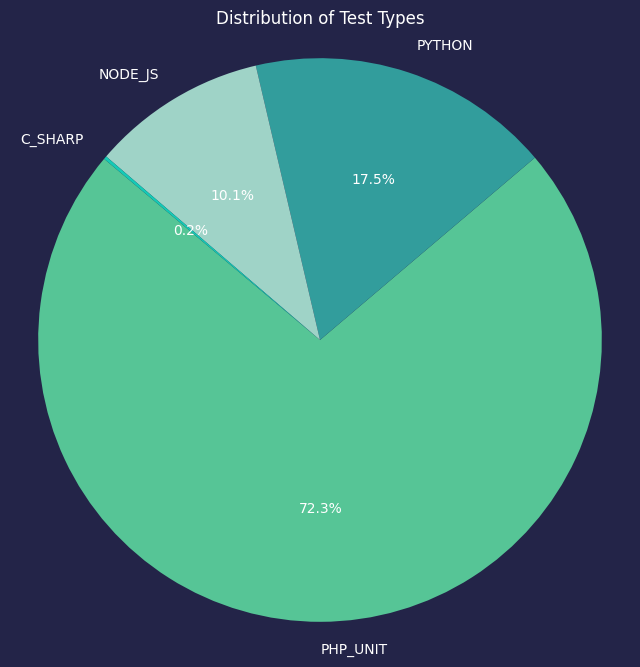

In [18]:
# Get the counts of unique values in the "test_type" column of the 'data_tests' DataFrame
unique_counts = data_tests["test_type"].value_counts()

# Adding colors to the pie chart
colors = ['#56C596', '#329D9C', '#9FD3C7', '#15CAB6']

# Create a pie chart
plt.figure(figsize=(8, 8), facecolor= '#232448')
plt.pie(unique_counts,
        labels=unique_counts.index,
        autopct='%1.1f%%',                      
        startangle=140,                         
        colors=colors,                          
        textprops={'color': 'white'}           
       )

# Set the title of the pie chart
plt.title("Distribution of Test Types", color='white')

# Set the aspect ratio to ensure a circular pie chart
plt.axis('equal')

# Display the pie chart
plt.show()


This data is unclear, php is sorted into multiple languages. Because of linting issues, lets find out what the real issues are.

### Finding the unique linting values per code language

Below we get a overview of the ammount of linting errors per code language. 

In [19]:
language_counts_linting = data_linting_result['file_name'].str.extract(r'\.(\w+)$').loc[:, 0].value_counts()

print(language_counts_linting)


php     486192
html    326956
js      251930
css      98299
sql      78774
py        3669
htm       3231
inc          5
Name: 0, dtype: int64


#### Vissulazing linting error's

Below we created a clear overview of the ammount of linting errros per code language. 

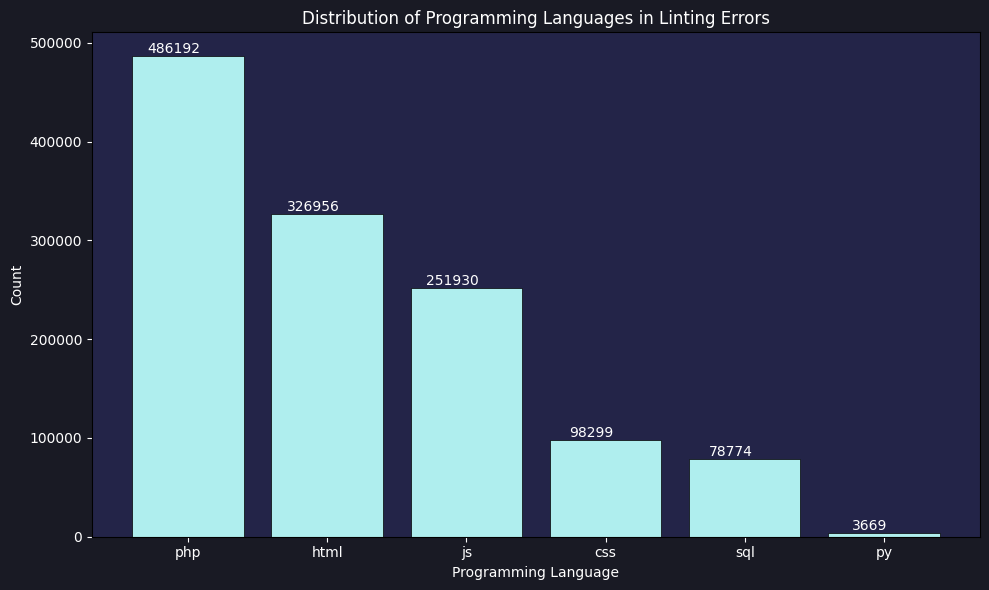

In [20]:
# Define a list of programming languages to be plotted
languages_to_plot = ['php', 'html', 'sql', 'js', 'css', 'py']

# Filter the counts for specified languages from the 'language_counts_linting' DataFrame
filtered_counts = language_counts_linting[language_counts_linting.index.isin(languages_to_plot)]

# Create a subplot with specified size and background color
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#191A24')

# Create a bar plot
bars = plt.bar(filtered_counts.index,                
               filtered_counts,                        
               color='paleturquoise',           
               edgecolor='black',                       
               linewidth=0.5                            
              )

# Set labels for X and Y axes, and the title of the plot
plt.xlabel('Programming Language', color='white')
plt.ylabel('Count', color='white')
plt.title('Distribution of Programming Languages in Linting Errors', color='white')

# Add text labels on top of each bar showing the count
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, 
             bar.get_height() + 0.05, 
             str(int(bar.get_height())), 
             ha='center', 
             va='bottom', 
             color='white'
            )

# Set the color of tick labels on both X and Y axes
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Adjust layout for better visualization and set background color for the entire plot
plt.tight_layout()
ax.set_facecolor('#232448')

# Display the bar plot
plt.show()


In summary, our analysis indicates that while programming languages differ, linting errors show a consistent pattern across them. PHP exhibits the highest error count, closely followed by HTML. This underscores the universal importance of adhering to coding standards for cleaner, more maintainable code.

#### What are the top 20 linting issues per code language?

Below we created a list showing the top 20 linting issues per code language.

In [21]:
# Go through each programming language along with its count in the 'language_counts_linting' dictionary
for language, count in language_counts_linting.items():

# Filter the data for the specific language using file extensions
    language_data = data_linting_result[data_linting_result['file_name'].str.endswith(f'.{language}')]

# Count the occurrences of each linting error code for the specific language
    error_codes = language_data['message'].value_counts()

# Print the top 20 linting error codes for the current language
    print(f'Top 20 {language.upper()} Linting Error Codes:')
    print(error_codes.head(20))
    print('\n')


Top 20 PHP Linting Error Codes:
Expected at least 1 space before "."; 0 found                      19739
Expected at least 1 space after "."; 0 found                       16569
Expected 1 space(s) after closing parenthesis; found 0             16504
Expected 1 space after closing brace; newline found                16030
Line indented incorrectly; expected 0 spaces, found 4              15888
Line indented incorrectly; expected at least 4 spaces, found 0     13219
Line indented incorrectly; expected at least 8 spaces, found 4     11564
Space before opening parenthesis of function call prohibited       11192
Line indented incorrectly; expected 4 spaces, found 0              10935
Header blocks must be separated by a single blank line             10798
Blank line found at start of control structure                     10629
Expected 1 space(s) after closing parenthesis; found newline       10563
Opening brace should be on a new line                              10454
Line indented incor

#### Visualizing the linting errors per linting type

We can use this information to find out what the most common linting error is and in what code language.
We created this table visual the get easier acces to the data.

In [22]:
language_counts_linting = data_linting_result['file_name'].str.extract(r'\.(\w+)$').loc[:, 0].value_counts()

print(language_counts_linting)


php     486192
html    326956
js      251930
css      98299
sql      78774
py        3669
htm       3231
inc          5
Name: 0, dtype: int64


#### Vissulazing linting error's

Below we created a clear overview of the ammount of linting errros per code language. 

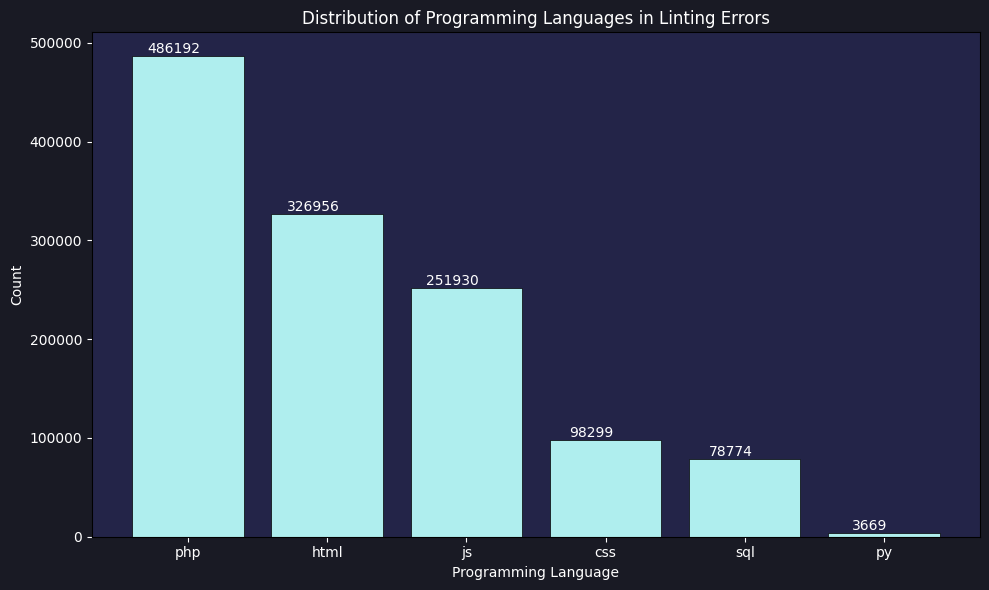

In [23]:
# Define a list of programming languages to be plotted
languages_to_plot = ['php', 'html', 'sql', 'js', 'css', 'py']

# Filter the counts for specified languages from the 'language_counts_linting' DataFrame
filtered_counts = language_counts_linting[language_counts_linting.index.isin(languages_to_plot)]

# Create a subplot with specified size and background color
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#191A24')

# Create a bar plot
bars = plt.bar(filtered_counts.index,                
               filtered_counts,                        
               color='paleturquoise',           
               edgecolor='black',                       
               linewidth=0.5                            
              )

# Set labels for X and Y axes, and the title of the plot
plt.xlabel('Programming Language', color='white')
plt.ylabel('Count', color='white')
plt.title('Distribution of Programming Languages in Linting Errors', color='white')

# Add text labels on top of each bar showing the count
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, 
             bar.get_height() + 0.05, 
             str(int(bar.get_height())), 
             ha='center', 
             va='bottom', 
             color='white'
            )

# Set the color of tick labels on both X and Y axes
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Adjust layout for better visualization and set background color for the entire plot
plt.tight_layout()
ax.set_facecolor('#232448')

# Display the bar plot
plt.show()


In summary, our analysis indicates that while programming languages differ, linting errors show a consistent pattern across them. PHP exhibits the highest error count, closely followed by HTML. This underscores the universal importance of adhering to coding standards for cleaner, more maintainable code.

#### What are the top 20 linting issues per code language?

Below we created a list showing the top 20 linting issues per code language.

In [24]:
# Go through each programming language along with its count in the 'language_counts_linting' dictionary
for language, count in language_counts_linting.items():

# Filter the data for the specific language using file extensions
    language_data = data_linting_result[data_linting_result['file_name'].str.endswith(f'.{language}')]

# Count the occurrences of each linting error code for the specific language
    error_codes = language_data['message'].value_counts()

# Print the top 20 linting error codes for the current language
    print(f'Top 20 {language.upper()} Linting Error Codes:')
    print(error_codes.head(20))
    print('\n')


Top 20 PHP Linting Error Codes:
Expected at least 1 space before "."; 0 found                      19739
Expected at least 1 space after "."; 0 found                       16569
Expected 1 space(s) after closing parenthesis; found 0             16504
Expected 1 space after closing brace; newline found                16030
Line indented incorrectly; expected 0 spaces, found 4              15888
Line indented incorrectly; expected at least 4 spaces, found 0     13219
Line indented incorrectly; expected at least 8 spaces, found 4     11564
Space before opening parenthesis of function call prohibited       11192
Line indented incorrectly; expected 4 spaces, found 0              10935
Header blocks must be separated by a single blank line             10798
Blank line found at start of control structure                     10629
Expected 1 space(s) after closing parenthesis; found newline       10563
Opening brace should be on a new line                              10454
Line indented incor

#### Visualizing the linting errors per linting type

We can use this information to find out what the most common linting error is and in what code language.
We created this table visual the get easier acces to the data.

In [25]:
# Extract the programming language from the file name and create a new 'language' column in the DataFrame
data_linting_result['language'] = data_linting_result['file_name'].str.extract(r'\.(\w+)$')

# Group the linting result data by 'language' and 'message', then count the occurrences
linting_message_counts = data_linting_result.groupby(['language', 'message']).size().reset_index(name='count')

# For each language, select the top 20 linting messages based on count
top_messages_per_language = linting_message_counts.groupby('language').apply(lambda x: x.nlargest(20, 'count')).reset_index(drop=True)

# Sort the table data by language and count in descending order
top_messages_per_language = top_messages_per_language.sort_values(by=['language', 'count'], ascending=[True, False])

# Create a DataFrame with selected columns for table data
table_data = top_messages_per_language[['language', 'message', 'count']]

# Define colors for text and borders in the table
text_color = '#56C596'
border_color = '#191A24'

# Create a Figure using Plotly for a table visualization
fig = go.Figure(data=[go.Table(
    # Define table header with column names and styling
    header=dict(values=['<b>Language<b>', '<b>Message<b>', '<b>Count<b>'],
                fill_color=border_color,
                line_color=border_color,
                font=dict(color=text_color),
                align='left'),
    # Populate table cells with data and styling
    cells=dict(values=[table_data['language'], table_data['message'], table_data['count']],
               fill_color='#232448',
               line_color=border_color,
               font=dict(color=text_color),
               align='left'))
])

# Set layout parameters for the figure
fig.update_layout(
    height=600,
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0),
)

# Display the table using Plotly
fig.show()


#### How many blast issues are there in the dataset?

This code provides us with the ammount of blast issues in the dataset. We use this data

## Visualizing blast error's
Making the visual more specific by sepporate the linting and blast issues, here are the blast error's;

### Finding the unique blast values

C:\Users\mitzb\AppData\Local\Temp\ipykernel_17168\2431916677.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



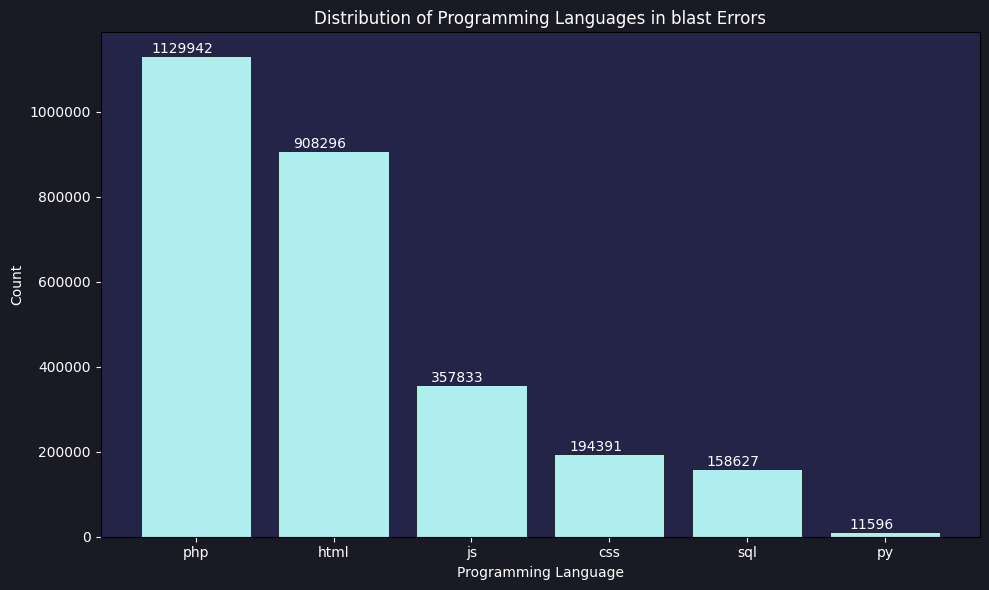

In [26]:
# Convert 'blast_review_id' columns to lowercase and remove leading/trailing whitespaces for both DataFrames
data_review_test_results['blast_review_id'] = data_review_test_results['blast_review_id'].str.lower().str.strip()
data_linting_result['blast_review_id'] = data_linting_result['blast_review_id'].str.lower().str.strip()

# Merge the two DataFrames on the 'blast_review_id' column using an inner join
merged_data = pd.merge(data_review_test_results, data_linting_result, on="blast_review_id", how="inner")

# Drop rows with missing values in the 'test_id' column
merged_data.dropna(subset=["test_id"], inplace=True)

# Get the programming languages from the 'file_name' column and count their occurrences
language_counts = merged_data['file_name'].str.extract(r'\.(\w+)$').loc[:, 0].value_counts()

# Define a list of programming languages to be plotted
languages_to_plot = ['php', 'html', 'sql', 'js', 'css', 'py']

# Filter language counts for the specified languages
filtered_counts = language_counts[language_counts.index.isin(languages_to_plot)]

# Create a bar plot with specified parameters
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#191A24')
bars = plt.bar(filtered_counts.index, filtered_counts, color='paleturquoise', edgecolor='black', linewidth=0.5)

# Set labels for X and Y axes, and the title of the plot
plt.xlabel('Programming Language', color='white')
plt.ylabel('Count', color='white')
plt.title('Distribution of Programming Languages in blast Errors', color='white')

# Format y-axis labels in plain style
plt.ticklabel_format(axis='y', style='plain')

# Add text labels on top of each bar showing the count
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.05, str(int(bar.get_height())), ha='center', va='bottom', color='white')

# Set the color of tick labels on both X and Y axes
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Adjust layout for better visualization and set background color for the entire plot
plt.tight_layout()
ax.set_facecolor('#232448')

# Display the plot
plt.show()


It is evident from the data that there are significantly more occurrences of blast errors than linting errors. PHP stands out as the programming language with the highest incidence of errors, followed closely by HTML. This observation underscores the importance of thorough testing and error handling, particularly in PHP and HTML development environments.